In [1]:
!pip install torch torchvision matplotlib scikit-image --quiet


In [2]:
import os, glob, random, shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import sobel
from google.colab import files

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [3]:
print("Upload your images (PNG/JPEG/TIFF)...")
uploaded = files.upload()

train_dir = "/content/train_images"
test_dir  = "/content/test_images"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

all_files = list(uploaded.keys())
random.shuffle(all_files)
split_idx = int(0.8 * len(all_files))
train_files = all_files[:split_idx]
test_files  = all_files[split_idx:]

for f in train_files:
    shutil.move(f"/content/{f}", os.path.join(train_dir, f))
for f in test_files:
    shutil.move(f"/content/{f}", os.path.join(test_dir, f))

print(f"✅ Training images: {len(train_files)}")
print(f"✅ Testing images:  {len(test_files)}")


Upload your images (PNG/JPEG/TIFF)...


Saving IMG-20250924-WA0001.jpg to IMG-20250924-WA0001.jpg
Saving IMG-20250924-WA0002.jpg to IMG-20250924-WA0002.jpg
Saving IMG-20250924-WA0003.jpg to IMG-20250924-WA0003.jpg
Saving IMG-20250924-WA0004.jpg to IMG-20250924-WA0004.jpg
✅ Training images: 3
✅ Testing images:  1


In [9]:
print("⚙️ Preparing dataset loader...")

class LunarDataset(Dataset):
    def __init__(self, folder, transform=None, hr_size=256, scale_factor=4):
        self.files = []
        for ext in ("*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
            self.files += glob.glob(os.path.join(folder, ext))
        self.transform = transform
        self.hr_size = hr_size
        self.scale = scale_factor

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("L")
        hr = img.resize((self.hr_size, self.hr_size), Image.BICUBIC)
        lr = hr.resize((self.hr_size // self.scale, self.hr_size // self.scale), Image.BICUBIC)
        if self.transform:
            lr_t = self.transform(lr)
            hr_t = self.transform(hr)
            return lr_t, hr_t
        else:
            return transforms.ToTensor()(lr), transforms.ToTensor()(hr)

transform = transforms.ToTensor()
train_dataset = LunarDataset(train_dir, transform=transform, hr_size=256, scale_factor=4)
test_dataset  = LunarDataset(test_dir,  transform=transform, hr_size=256, scale_factor=4)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

print(f"✅ Dataset ready: {len(train_dataset)} training samples, {len(test_dataset)} testing samples")


⚙️ Preparing dataset loader...
✅ Dataset ready: 3 training samples, 1 testing samples


In [11]:
class ResBlock(nn.Module):
    def __init__(self, n_feats, res_scale=0.1):
        super(ResBlock, self).__init__()
        self.res_scale = res_scale
        self.conv1 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

    def forward(self, x):
        res = self.conv1(x)
        res = self.relu(res)
        res = self.conv2(res)
        res = res * self.res_scale
        return x + res

class Upsampler(nn.Sequential):
    def __init__(self, scale, n_feats):
        m = []
        if (scale & (scale - 1)) == 0:
            for _ in range(int(scale).bit_length() - 1):
                m.append(nn.Conv2d(n_feats, 4 * n_feats, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
                m.append(nn.ReLU(inplace=True))
        elif scale == 3:
            m.append(nn.Conv2d(n_feats, 9 * n_feats, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
            m.append(nn.ReLU(inplace=True))
        else:
            raise NotImplementedError
        super(Upsampler, self).__init__(*m)

class EDSR(nn.Module):
    def __init__(self, scale_factor=4, n_resblocks=16, n_feats=64, res_scale=0.1):
        super(EDSR, self).__init__()
        self.scale = scale_factor
        self.head = nn.Conv2d(1, n_feats, kernel_size=3, padding=1)
        body = [ResBlock(n_feats, res_scale) for _ in range(n_resblocks)]
        self.body = nn.Sequential(*body)
        self.tail_conv = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)
        self.upsampler = Upsampler(scale_factor, n_feats)
        self.final_conv = nn.Conv2d(n_feats, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        res = self.tail_conv(res)
        x = x + res
        x = self.upsampler(x)
        x = self.final_conv(x)
        return x

print("✅ EDSR model defined")


✅ EDSR model defined


In [12]:
print("⚡ Initializing model, loss, optimizer...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EDSR(scale_factor=4, n_resblocks=16, n_feats=64, res_scale=0.1).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

import math
def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100.0
    return 20 * torch.log10(max_val / torch.sqrt(mse))

print("✅ Training setup complete")


⚡ Initializing model, loss, optimizer...
✅ Training setup complete


In [13]:
epochs = 10
best_psnr = 0.0
os.makedirs("/content/edsr_checkpoints", exist_ok=True)

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        sr = model(lr)
        min_h, min_w = min(sr.shape[2], hr.shape[2]), min(sr.shape[3], hr.shape[3])
        sr, hr = sr[:, :, :min_h, :min_w], hr[:, :, :min_h, :min_w]
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_loader)

    # Validation PSNR
    model.eval()
    with torch.no_grad():
        psnr_total = 0.0
        for lr, hr in test_loader:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            min_h, min_w = min(sr.shape[2], hr.shape[2]), min(sr.shape[3], hr.shape[3])
            sr, hr = sr[:, :, :min_h, :min_w], hr[:, :, :min_h, :min_w]
            psnr_total += psnr(sr, hr).item()
        avg_psnr = psnr_total / len(test_loader)

    print(f"Epoch [{epoch}/{epochs}] Loss: {avg_loss:.6f}, Val_PSNR: {avg_psnr:.3f} dB")

    if avg_psnr > best_psnr:
        best_psnr = avg_psnr
        torch.save(model.state_dict(), "/content/edsr_checkpoints/edsr_best.pth")
        print(f"  -> Saved best model with PSNR {best_psnr:.3f} dB")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch [1/10] Loss: 0.200195, Val_PSNR: 15.206 dB
  -> Saved best model with PSNR 15.206 dB
Epoch [2/10] Loss: 0.179812, Val_PSNR: 16.536 dB
  -> Saved best model with PSNR 16.536 dB
Epoch [3/10] Loss: 0.159238, Val_PSNR: 18.261 dB
  -> Saved best model with PSNR 18.261 dB
Epoch [4/10] Loss: 0.136384, Val_PSNR: 20.640 dB
  -> Saved best model with PSNR 20.640 dB
Epoch [5/10] Loss: 0.112142, Val_PSNR: 24.006 dB
  -> Saved best model with PSNR 24.006 dB
Epoch [6/10] Loss: 0.093312, Val_PSNR: 27.280 dB
  -> Saved best model with PSNR 27.280 dB
Epoch [7/10] Loss: 0.087247, Val_PSNR: 26.207 dB
Epoch [8/10] Loss: 0.091580, Val_PSNR: 24.060 dB
Epoch [9/10] Loss: 0.096713, Val_PSNR: 23.347 dB
Epoch [10/10] Loss: 0.097525, Val_PSNR: 23.971 dB


In [14]:
os.makedirs("/content/edsr_outputs", exist_ok=True)
model.eval()
with torch.no_grad():
    for i, (lr, hr) in enumerate(test_loader):
        lr = lr.to(device)
        sr = model(lr).cpu().squeeze(0)
        sr_np = sr.clamp(0.0, 1.0).squeeze().numpy()
        out_path = f"/content/edsr_outputs/sr_{i}.png"
        plt.imsave(out_path, sr_np, cmap="gray", vmin=0, vmax=1)
print("✅ Super-res outputs saved in /content/edsr_outputs")


✅ Super-res outputs saved in /content/edsr_outputs


In [16]:
def generate_hazard_map(image_path, save_path):
    img = Image.open(image_path).convert("L")
    img = np.array(img, dtype=np.float32) / 255.0
    edges = sobel(img)
    edges = (edges - edges.min()) / (edges.max() - edges.min() + 1e-8)
    plt.imsave(save_path, edges, cmap="hot", vmin=0, vmax=1)

# ✅ Make sure output folder exists
hazard_dir = "/content/edsr_outputs/hazard_maps"
os.makedirs(hazard_dir, exist_ok=True)

for img_path in glob.glob("/content/edsr_outputs/sr_*.png"):
    base_name = os.path.basename(img_path).replace("sr_", "hazard_")
    save_path = os.path.join(hazard_dir, base_name)
    generate_hazard_map(img_path, save_path)

print(f"✅ Hazard maps saved in {hazard_dir}")


✅ Hazard maps saved in /content/edsr_outputs/hazard_maps


📊 Visualizing ALL test results...


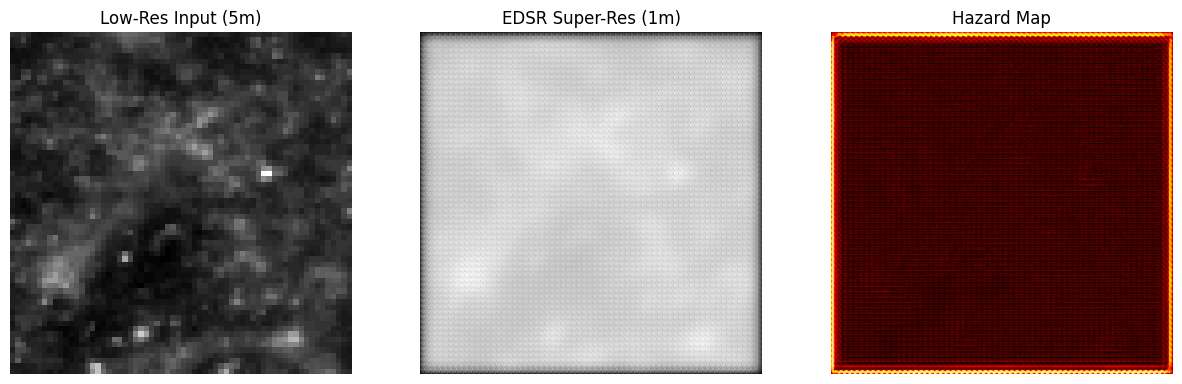

✅ Visualization done for index 0


In [21]:
print("📊 Visualizing ALL test results...")

def visualize_all_results(test_loader, sr_root="/content/edsr_outputs"):
    sr_dir = sr_root
    haz_dir = os.path.join(sr_root, "hazard_maps")

    # Loop over all test images
    for idx, (lr, hr) in enumerate(test_loader):
        sr_path = os.path.join(sr_dir, f"sr_{idx}.png")
        haz_path = os.path.join(haz_dir, f"hazard_{idx}.png")

        # Safety check (skip if files missing)
        if not os.path.exists(sr_path) or not os.path.exists(haz_path):
            print(f"⚠️ Skipping index {idx}, missing files")
            continue

        lr_np = lr.squeeze().cpu().numpy()
        sr_np = np.array(Image.open(sr_path).convert("L"))
        haz_np = np.array(Image.open(haz_path).convert("L"))

        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1); plt.imshow(lr_np, cmap="gray"); plt.title("Low-Res Input (5m)"); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(sr_np, cmap="gray"); plt.title("EDSR Super-Res (1m)"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(haz_np, cmap="hot"); plt.title("Hazard Map"); plt.axis("off")
        plt.show()

        print(f"✅ Visualization done for index {idx}")

# Run visualization for all test images
visualize_all_results(test_loader, sr_root="/content/edsr_outputs")
